# State Space Model of Learning - Performance Evaluation

This notebook demonstrates usage of the framework for the state space model of learning problem. Additionally, it is used to create Fig. 1 in section IV.A.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli as bern
import time
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},font_scale=2)
%matplotlib inline

import sys
sys.path
sys.path.append('../python/')
from ssml import ssml
from ssml_particle import particle_smooth
from ssml_kalman import kalman_smooth

import pickle

# Temporary to avoid the "if self._edgecolors == str('face')" FutureWarning
import warnings
warnings.filterwarnings('ignore')

## *Generative Model*
First we'll create functions for generating a learning state and the subsequent observations.

In [2]:
def gen_learning_state(N=50,sparse_variations=False,plot=False,
                       gamma=0.1,phi=0.99,sigv=0.03,sigchi=0.1,p=0.1):

    X = np.zeros((N,))

    if sparse_variations:
        for n in range(1,len(X)):
            if np.random.uniform() < p:
                X[n] = X[n-1] + sigchi*(np.random.chisquare(2))
            else:
                X[n] = X[n-1]

    else:
        V = np.sqrt(sigv)*np.random.randn(N) # Gaussian vector for learning state random walk
        X[0] = gamma + V[0]
        for n in range(1,len(X)):
            X[n] = gamma + phi*X[n-1] + V[n]

    if plot:
        plt.figure(figsize=(15,4))
        plt.plot(range(1,N+1),X,'o')
        plt.xlim(0.75,N+0.5)
        plt.xticks(range(1,N+1))
        plt.xlabel('Trial Number')
        plt.ylabel('Learning State')
        plt.tight_layout();
    
    return X

In [3]:
def gen_reaction_time(X,delta=0.369,h=-0.38,sigg=0.75,plot=False):
    N = len(X)
    G = np.sqrt(sigg)*np.random.randn(N)
    Q = delta + h*X + G

    if plot:
        plt.figure(figsize=(15,4))
        plt.plot(range(1,N+1),Q,'o')
        plt.xlim(0.75,N+0.5)
        plt.xticks(range(1,N+1))
        plt.xlabel('Trial Number')
        plt.ylabel('Log Reaction Time')
        plt.tight_layout();
    
    return Q

In [4]:
def gen_trial_outcome(X,mu=-1.4170,eta=1.75,plot=False):
    N = len(X)
    p = np.exp(mu + eta*X)/(1 + np.exp(mu+eta*X))
    M = np.zeros((N,))
    col = []
    for n in range(len(M)):
        M[n] = bern.rvs(p[n],size=1)
        if M[n] == 1: col.append('b')
        else: col.append('r')

    if plot:
        plt.figure(figsize=(15,4))
        plt.plot([0]*(N+2),'k--',[1]*(N+2),'k--')
        plt.scatter(range(1,N+1),M,c=col,s=50)
        plt.xlim(0.75,N+0.5)
        plt.xticks(range(1,N+1))
        plt.ylim([-.1,1.1])
        plt.xlabel('Trial Number')
        plt.ylabel('Correct/Incorrect (1/0) Outcome')
        plt.tight_layout();
    return M

In [5]:
def gen_spiking(X,T=5,Del=0.001,psi=-3.5,g=2.2,c=[-20,-5,1,3],plot=False):
    J = int(T/Del)
    N = len(X)
    R = np.zeros((N,J))
    for n in range(N):
        for j in range(J):
            c_sum = 0
            for s in range(len(c)):
                if(j-(s+1)>=0):
                    c_sum += c[s]*R[n,j-(s+1)]
            lam_nj = np.exp(psi + g*X[n] + c_sum)
            R[n,j] = bern.rvs(lam_nj*Del*np.exp(-lam_nj*Del),size=1)

    if plot:
        R_vec = R.reshape(N*J,1)
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(0,N*J/1000,1/1000),R_vec,linewidth=0.3)
        plt.xlim([0,N*J/1000])
        plt.xticks(range(0,130,5))
        plt.xlabel('Time (s)')
        plt.ylabel('Spiking Activity')
        plt.tight_layout();
    
    return R

## *Gaussian Learning State*

First we'll run multiple trials with the standard state space model of learning model with the Gaussian random walk. Start by defining the parameters:

In [6]:
# Learning State
N=25; gamma=0.1; phi=0.99; sigv=0.03
# Reaction time
delta=0.369; h=-0.38; sigg=0.75
# Trial outcomes
mu=-1.4170; eta=1.75
# Spiking 
T=5; Del=0.001; psi=-3.5; g=2.2; c=[-20,-5,1,3]; J = int(T/Del)

# ADMM params
rho = 30
max_iters = 25
verbosity = 0

# Kalman param
eps=0.0000001

# Particle param
num_p=100

# The parameters that get passed into each solution method
params = [gamma,phi,sigv,delta,h,sigg,mu,eta,psi,g,c,Del,J]

# Number of trials to conduct
num_trials = 50

In [7]:
results = {'admm':{'rmse':[],'time':[]},
           'kalman':{'rmse':[],'time':[]},
           'particle':{'rmse':[],'time':[]}}

for trial in range(num_trials):
    
    # generate learning states
    X = gen_learning_state(N)
    
    # create observations
    Q = gen_reaction_time(X)
    M = gen_trial_outcome(X)
    R = gen_spiking(X)
    
    # make predictions and store results
    start = time.time()
    x_admm = ssml(observations=(M,Q,R), rho=rho, params=params, max_iters=max_iters, verbosity=verbosity)
    results['admm']['time'].append(time.time()-start)
    results['admm']['rmse'].append(np.linalg.norm(X-x_admm)/np.sqrt(N))
    
    start = time.time()
    x_kalman = kalman_smooth(obs=(M,Q,R),eps=eps,params=params)
    results['kalman']['time'].append(time.time()-start)
    results['kalman']['rmse'].append(np.linalg.norm(X-x_kalman)/np.sqrt(N))
    
    start = time.time()
    x_particle = particle_smooth(obs=(M,Q,R),params=params,num_p=num_p)
    results['particle']['time'].append(time.time()-start)
    results['particle']['rmse'].append(np.linalg.norm(X-x_particle)/np.sqrt(N))

    print('\n---------- Trial %i ----------'%(trial+1))
    print('ADMM - RMSE: %0.3f, Time: %0.1f'%(results['admm']['rmse'][trial],results['admm']['time'][trial]))
    print('Kalman - RMSE: %0.3f, Time: %0.1f'%(results['kalman']['rmse'][trial],results['kalman']['time'][trial]))
    print('Particle - RMSE: %0.3f, Time: %0.1f'%(results['particle']['rmse'][trial],results['particle']['time'][trial]))


---------- Trial 1 ----------
ADMM - RMSE: 0.151, Time: 1.9
Kalman - RMSE: 0.145, Time: 2.6
Particle - RMSE: 0.166, Time: 49.1

---------- Trial 2 ----------
ADMM - RMSE: 0.119, Time: 1.6
Kalman - RMSE: 0.119, Time: 2.4
Particle - RMSE: 0.146, Time: 49.4

---------- Trial 3 ----------
ADMM - RMSE: 0.157, Time: 1.7
Kalman - RMSE: 0.163, Time: 2.4
Particle - RMSE: 0.137, Time: 52.3

---------- Trial 4 ----------
ADMM - RMSE: 0.190, Time: 1.9
Kalman - RMSE: 0.155, Time: 2.5
Particle - RMSE: 0.143, Time: 53.5

---------- Trial 5 ----------
ADMM - RMSE: 0.220, Time: 1.8
Kalman - RMSE: 0.241, Time: 2.7
Particle - RMSE: 0.195, Time: 52.5

---------- Trial 6 ----------
ADMM - RMSE: 0.209, Time: 1.7
Kalman - RMSE: 0.244, Time: 2.5
Particle - RMSE: 0.183, Time: 52.0

---------- Trial 7 ----------
ADMM - RMSE: 0.146, Time: 1.7
Kalman - RMSE: 0.153, Time: 2.8
Particle - RMSE: 0.158, Time: 54.6

---------- Trial 8 ----------
ADMM - RMSE: 0.229, Time: 1.9
Kalman - RMSE: 0.235, Time: 2.8
Particle - 

In [8]:
print('ADMM - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['admm']['rmse']),np.mean(results['admm']['time'])))
print('Kalman - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['kalman']['rmse']),np.mean(results['kalman']['time'])))
print('Particle - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['particle']['rmse']),np.mean(results['particle']['time'])))

ADMM - RMSE: 0.165, Time: 1.8
Kalman - RMSE: 0.168, Time: 2.6
Particle - RMSE: 0.188, Time: 53.5


## *Sparse Variation Learning State*

In [11]:
# Learning State
N=50; gamma=0.1; phi=0.99; sigv=0.03; sigchi = 0.1; p = 0.1
# Reaction time
delta=0.369; h=-0.38; sigg=0.75
# Trial outcomes
mu=-1.4170; eta=1.75
# Spiking 
T=5; Del=0.001; psi=-3.5; g=2.2; c=[-20,-5,1,3]; J = int(T/Del)

# ADMM params
rho = 30
max_iters = 75
verbosity = 0
beta = 15

# Kalman param
eps=0.0000001

# Particle param
num_p=100

# The parameters that get passed into each solution method
admm_params = [gamma,phi,sigv,delta,h,sigg,mu,eta,psi,g,c,Del,J,beta]
kalman_params = [0,1,4*(sigchi**2),delta,h,sigg,mu,eta,psi,g,c,Del,J]
particle_params = [gamma,phi,sigv,delta,h,sigg,mu,eta,psi,g,c,Del,J,p,sigchi]

# Number of trials to conduct
num_trials = 20

In [12]:
results = {'admm':{'rmse':[],'time':[]},
           'kalman':{'rmse':[],'time':[]},
           'particle':{'rmse':[],'time':[]}}

for trial in range(num_trials):
    
    # generate learning states
    X = gen_learning_state(N,sparse_variations=True)
    
    # create observations
    Q = gen_reaction_time(X)
    M = gen_trial_outcome(X)
    R = gen_spiking(X)
    
    # make predictions and store results
    start = time.time()
    x_admm = ssml(observations=(M,Q,R), rho=rho, params=admm_params, max_iters=max_iters, verbosity=verbosity,sparse=True)
    results['admm']['time'].append(time.time()-start)
    results['admm']['rmse'].append(np.linalg.norm(X-x_admm)/np.sqrt(N))
    
    start = time.time()
    x_kalman = kalman_smooth(obs=(M,Q,R),eps=eps,params=kalman_params)
    results['kalman']['time'].append(time.time()-start)
    results['kalman']['rmse'].append(np.linalg.norm(X-x_kalman)/np.sqrt(N))
    
    start = time.time()
    x_particle = particle_smooth(obs=(M,Q,R),params=particle_params,num_p=num_p,sparse=True,forward_only=True)
    results['particle']['time'].append(time.time()-start)
    results['particle']['rmse'].append(np.linalg.norm(X-x_particle)/np.sqrt(N))

    print('\n---------- Trial %i ----------'%(trial+1))
    print('ADMM - RMSE: %0.3f, Time: %0.1f'%(results['admm']['rmse'][trial],results['admm']['time'][trial]))
    print('Kalman - RMSE: %0.3f, Time: %0.1f'%(results['kalman']['rmse'][trial],results['kalman']['time'][trial]))
    print('Particle - RMSE: %0.3f, Time: %0.1f'%(results['particle']['rmse'][trial],results['particle']['time'][trial]))


---------- Trial 1 ----------
ADMM - RMSE: 0.183, Time: 7.1
Kalman - RMSE: 0.223, Time: 5.1
Particle - RMSE: 0.126, Time: 105.0

---------- Trial 2 ----------
ADMM - RMSE: 0.063, Time: 6.4
Kalman - RMSE: 0.198, Time: 5.0
Particle - RMSE: 0.125, Time: 103.5

---------- Trial 3 ----------
ADMM - RMSE: 0.091, Time: 7.5
Kalman - RMSE: 0.127, Time: 5.4
Particle - RMSE: 0.129, Time: 104.3

---------- Trial 4 ----------
ADMM - RMSE: 0.072, Time: 6.6
Kalman - RMSE: 0.196, Time: 4.8
Particle - RMSE: 0.098, Time: 107.6

---------- Trial 5 ----------
ADMM - RMSE: 0.168, Time: 7.2
Kalman - RMSE: 0.217, Time: 5.4
Particle - RMSE: 0.168, Time: 100.6

---------- Trial 6 ----------
ADMM - RMSE: 0.188, Time: 7.0
Kalman - RMSE: 0.179, Time: 5.4
Particle - RMSE: 0.310, Time: 106.3

---------- Trial 7 ----------
ADMM - RMSE: 0.300, Time: 7.2
Kalman - RMSE: 0.252, Time: 5.1
Particle - RMSE: 0.320, Time: 106.8

---------- Trial 8 ----------
ADMM - RMSE: 0.051, Time: 7.1
Kalman - RMSE: 0.186, Time: 5.2
Part

In [13]:
print('ADMM - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['admm']['rmse']),np.mean(results['admm']['time'])))
print('Kalman - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['kalman']['rmse']),np.mean(results['kalman']['time'])))
print('Particle - RMSE: %0.3f, Time: %0.1f'%(np.mean(results['particle']['rmse']),np.mean(results['particle']['time'])))

ADMM - RMSE: 0.141, Time: 7.0
Kalman - RMSE: 0.181, Time: 5.2
Particle - RMSE: 0.186, Time: 105.7


## *Figure Generation*

In [15]:
save_figs = True
fig_dir = './'

### Gaussian State

In [293]:
N = 25
# load learning state used in paper (or regenerate)
X = pickle.load(open( "pickles/gaussian_state_X.p", "rb" )) #gen_learning_state(N)
# create observations
Q = gen_reaction_time(X)
M = gen_trial_outcome(X)
R = gen_spiking(X)

In [295]:
x_admm = ssml(observations=(M,Q,R), rho=rho, params=params, max_iters=25, verbosity=verbosity)
x_kalman = kalman_smooth(obs=(M,Q,R),eps=eps,params=params)
x_particle = particle_smooth(obs=(M,Q,R),params=params,num_p=num_p)

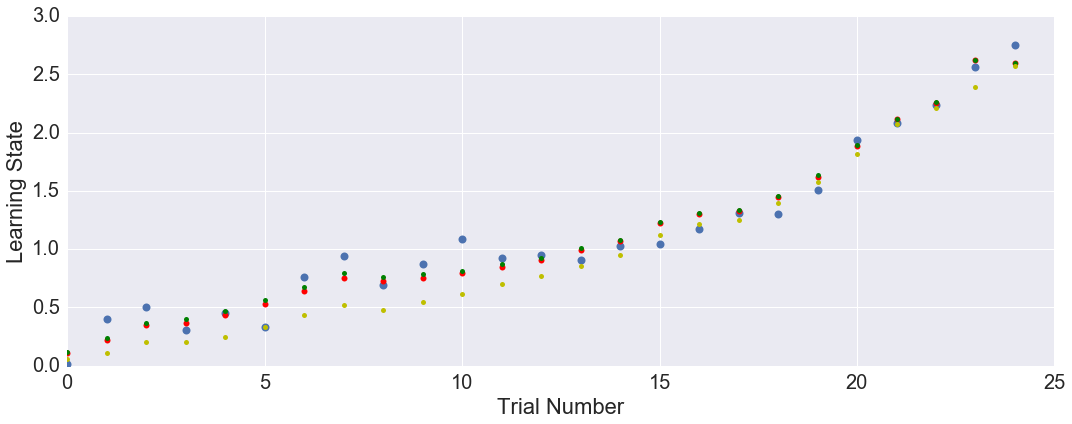

In [297]:
plt.figure(figsize=(15,6))
ns = range(N)


plt.plot(ns,X,'o',label='True Learning State',markersize=8)
plt.plot(ns,x_admm,'ro',label='ADMM Estimate',markersize=6)
plt.plot(ns,x_kalman,'go',label='FIS Estimate',markersize=5)
plt.plot(ns,x_particle,'yo',label='SMC Estimate',markersize=5)

#plt.legend(loc=2)
plt.xlabel('Trial Number')
plt.ylabel('Learning State');
plt.tight_layout()
if save_figs: plt.savefig(fig_dir + 'ssml_gauss_state.png',dpi=300)
plt.show()

### Sparse Variations

In [262]:
N = 50
# load learning state used in paper (or regenerate)
X = pickle.load(open( "pickles/sparse_variation_X.p", "rb" )) #gen_learning_state(N,sparse_variations=True)
# create observations
Q = gen_reaction_time(X)
M = gen_trial_outcome(X)
R = gen_spiking(X)

In [288]:
x_admm = ssml(observations=(M,Q,R), rho=rho, params=admm_params, max_iters=75, verbosity=verbosity,sparse=True)
x_kalman = kalman_smooth(obs=(M,Q,R),eps=eps,params=kalman_params)
x_particle = particle_smooth(obs=(M,Q,R),params=particle_params,num_p=num_p,sparse=True,forward_only=True)

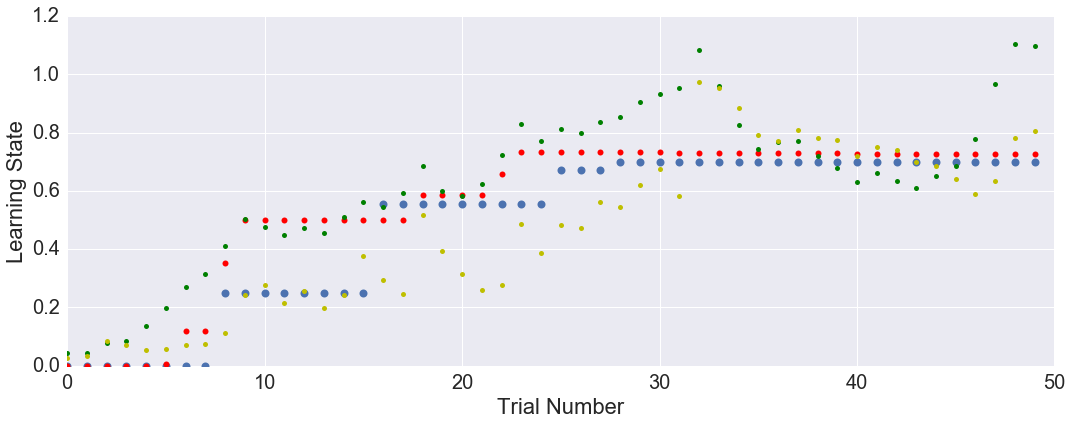

In [289]:
plt.figure(figsize=(15,6))
ns = range(N)

plt.plot(ns,X,'o',label='True Learning State',markersize=8)
plt.plot(ns,x_admm,'ro',label='ADMM Estimate',markersize=6)
plt.plot(ns,x_kalman,'go',label='FIS Estimate',markersize=5)
plt.plot(ns,x_particle,'yo',label='SMC Estimate',markersize=5)

#plt.legend(loc=2)
plt.xlabel('Trial Number')
plt.ylabel('Learning State');
plt.tight_layout()
if save_figs: plt.savefig(fig_dir + 'ssml_sparse_variations.png',dpi=300)
plt.show()